# Advanced Lane Detection

#### This Jupyter notebook aims to demostrate Lane Detection using Computer Vision methods explained in Udacity coursework.

In [1]:
## Import all the require modules here
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload

In [14]:
## Global Variable Definitions

CHESSBOARD_PATTERN_SIZE = (9, 6)

M    = []  # Camera Matrix
DIST = []  # Distortion co-efficients 

THRESH_GRAY  = (150, 255)  # threshold values for gray scale conversion
THRESH_SCHAN = (200, 255)  # threshold values for S Channel in HLS Space
THRESH_SOBX  = (30, 255)   # threshold values for SobelX filter


PERSPECTIVE_SRC = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) # perspective source points
PERSPECTIVE_DST = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]])  # perspective destionation points


In [3]:
## Read the given list of images for Camera calibration and Testing, using glob

# retrieve calibration images
images_cal = np.array([plt.imread(i) for i in glob.glob('./camera_cal/calibration*.jpg')])

# retrieve test images
images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')]) 

image_size = (images[0].shape[1], images[0].shape[0])

print('Calibration Images => ', images_cal.shape)
print('Test Images => ', images.shape)                  

Calibration Images =>  (20,)
Test Images =>  (8, 720, 1280, 3)


### Camera Calibration

Define a method for Camera calibration using OpenCVs calibrateCamera function. The function calibrateCamera will require an array of object points and the detected corners

In [4]:
def calibrateCamera(images, image_size):

    ## Prepare 3D Object points
    zero3D = np.zeros((CHESSBOARD_PATTERN_SIZE[0]*CHESSBOARD_PATTERN_SIZE[1],3), np.float32)
    zero3D[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # get chessboard corners for all the images
    for idx, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_PATTERN_SIZE, None)

        # if found, add object points and image points
        if ret == True:
            objpoints.append(zero3D)
            imgpoints.append(corners)

    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

    return mtx, dist

##### Display Camera Matrix & Distortion Co-efficients

In [5]:
M, DIST = calibrateCamera(images_cal,image_size)

print("Camera Matrix => ")
print(M)

print("Distortion Coefficients => ")
print(DIST)

Camera Matrix => 
[[  1.15662906e+03   0.00000000e+00   6.69041437e+02]
 [  0.00000000e+00   1.15169194e+03   3.88137240e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Coefficients => 
[[-0.2315715  -0.12000537 -0.00118338  0.00023305  0.15641571]]


##### Method to undistort given images

In [6]:
# method to undistort a given image
def undistort(image, dist_mtx=M, dist_param=DIST):
    return cv2.undistort(image, dist_mtx, dist_param, None, dist_mtx)

##### Test calibrate and distort functions

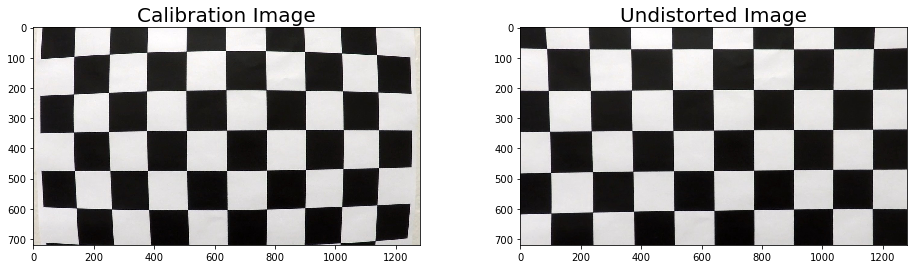

In [7]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (16,4))
ax1.imshow(images_cal[0])
ax1.set_title('Calibration Image',fontsize=20)
ax2.imshow(undistort(images_cal[0]))
ax2.set_title('Undistorted Image',fontsize=20)

### Image Binarization

##### Method to convert a given images into a binary image

* Use color transforms, gradients, etc., to create a thresholded binary image.



This methods applies the following preprocessing algorithms in the specified order
> retrieve S-channel from HLS Space
>
> apply binary threshold on S-channel
>
> compute Sobel X filter on S-channel
>
> apply binary threshold on SobelX
>
> combine both the binary images from above
>
> retrive grayscale image and apply binary threshold
>
> compute bitwise AND between the combined binaries and grayscale binary
    

In [8]:
def binarizeImage(img, threshS=THRESH_SCHAN, threshSX=THRESH_SOBX, threshGray=THRESH_GRAY):
    """ Pipeline for applying image binarization
    
    This methods applies the following preprocessing algorithms in the specified order
    ** retrieve S -channel from HLS Space
    ** apply binary threshold on S -channel
    ** compute Sobel X filter on S -channel
    ** apply binary threshold on SobelX
    ** combine both the binary images from above
    ** retrive grayscale image and apply binary threshold
    ** compute bitwise AND between the combined binaries and grayscale binary
    """
    # pick color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= threshS[0]) & (s_channel <= threshS[1])] = 1

    # apply Sobel filter with orientation on X-axis
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshSX[0]) & (scaled_sobel <= threshSX[1])] = 1

    combined_sobelx_color = np.zeros_like(sxbinary)
    combined_sobelx_color[(s_binary == 1) | (sxbinary == 1)] = 1

    ## binarize a grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g_binary = np.zeros_like(gray)
    g_binary[(gray >= threshGray[0]) & (gray <= threshGray[1])] = 1

    color_binary = cv2.bitwise_and(combined_sobelx_color, g_binary)

    return color_binary

##### Test binarization method

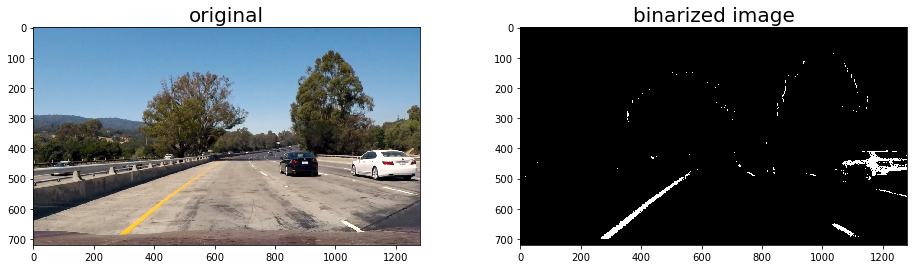

In [17]:
## procedure to test the above method. get a random test image and apply the above method
image = images[np.random.randint(8)]
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(image)
ax1.set_title('original',fontsize=20)

binary_image = binarizeImage(undistort(image))
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('binarized image',fontsize=20)

### Perspective Transformation

* Apply a perspective transform to rectify binary image ("birds-eye view").


In [15]:
def perspectiveTransformation(img, src=PERSPECTIVE_SRC, dst=PERSPECTIVE_DST):
    img_size = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(img, M, img_size[::-1], flags=cv2.INTER_LINEAR)
    return warped_img

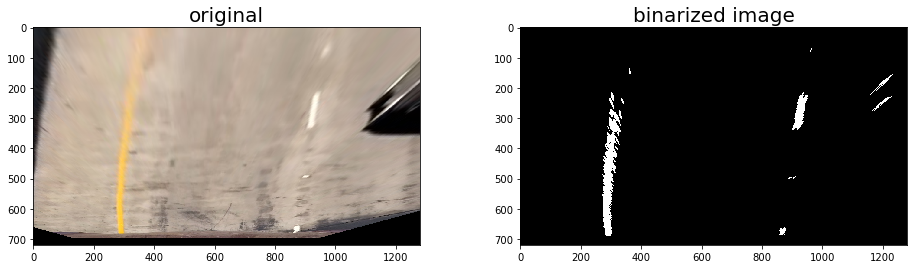

In [19]:
# Test perspective tranformation for both original image and binarized-undistored images
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(perspectiveTransformation(image))
ax1.set_title('original',fontsize=20)
ax2.imshow(perspectiveTransformation(binary_image), cmap='gray')
ax2.set_title('binarized image',fontsize=20)

In [12]:
img_size = image.shape[:2]
print(img_size)

print(img_size[::-1])

(720, 1280)
(1280, 720)
